In [1]:
!pip install opencv-contrib-python
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn import linear_model
from sklearn.metrics import r2_score

zsh:1: command not found: pip


ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz



--2024-05-14 12:28:09--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-14 12:28:09--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-14 12:28:09--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'cf2a926d2165322adcd19d2e88b2eb1cd200ea5c')
confirm_checksum('examples.npz', '0fadc9226e4c0efb4479c5c1bf79491d75828ad3')
confirm_checksum('test_images.npz', 'c7b4b297c7e5c5009706f893ad1fb77a2aa73f95')



In [ ]:
import numpy as np

def load_data():
    # Load the data using np.load
    data = np.load('training_images.npz', allow_pickle=True)
    train_images = data['images']
    train_pts = data['points']
    test_data = np.load('test_images.npz', allow_pickle=True)
    test_images = test_data['images']
    example_data = np.load('examples.npz', allow_pickle=True)
    example_images = example_data['images']
    return train_images, train_pts, test_images, example_images

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Define colors for eyes and lips
eye_color = (0, 0, 255)  # Red
lip_color = (0, 255, 0)  # Green

def color_fill(image, point_set):
    # Create a blank mask for the selected image
    mask = np.zeros_like(image, dtype=np.uint8)
    left_eye_points = point_set[[21, 22, 24, 25]]
    # Select points for the right eye (28, 29, 31, 32)
    right_eye_points = point_set[[27, 28, 30, 31]]
    lip_points = point_set[32:44]
    # Convert the points to integer type
    left_eye_points_int = left_eye_points.astype(int)
    right_eye_points_int = right_eye_points.astype(int)
    lip_points_int = lip_points.astype(int)
    # Draw filled polygons for left eye
    cv2.fillPoly(mask, [left_eye_points_int.reshape((-1, 1, 2))], eye_color)
    # Draw filled polygons for right eye
    cv2.fillPoly(mask, [right_eye_points_int.reshape((-1, 1, 2))], eye_color)
    cv2.fillPoly(mask, [lip_points_int.reshape((-1, 1, 2))], lip_color)
    # Apply the mask to the original image to change eye color
    # beta = (1.0 - alpha)
    # dst = cv.addWeighted(src1, alpha, src2, beta, 0.0)
    result_image = cv2.addWeighted(image, 0.5, mask, 1.0, 0)
    # Display the result
    plt.imshow(result_image)
    plt.show()


In [ ]:
import pickle


def save_model(model, name: str):
    pickle.dump(model, open(name, 'wb'))

def load_model(name: str):
    load_model=pickle.load(open(name, 'rb'))
    return load_model



In [ ]:
from tqdm.auto import tqdm
from sklearn import linear_model
import numpy as np
import cv2

class Linear_Model:
    def __init__(self, images, pts):
        # store the optimal point locations
        self.pts = self.get_optimal_pts(pts)
        self.models = []
        # initialize a linear regression model, compute the feature descriptors for a specific point,
        # and fit each linear regressor with the corresponding descriptors and ground truth point locations
        for i in tqdm(range(len(pts[0]))):
            self.models.append(linear_model.LinearRegression())
            self.models[i].fit(self.compute_pt_img_des(images, i), pts[:, i])

    def predict(self, images):
        """
        Returns the predicted points for all given images.
        :param images: The images that are going to have their face alignment points predicted.
        :return: The predicted points for all given images.
        """
        pred_pts = []
        for i in tqdm(range(len(self.pts))):
            pred_pts.append(self.models[i].predict(self.compute_pt_img_des(images, i)))
        # reshaping to make the predictions have a shape of (num_of_samples, num_of_points, 2)
        # while still perserving the right point-to-image relationship
        return np.array([[pred_pts[i][j] for i in range(len(pred_pts))] for j in range(len(pred_pts[0]))])

    def compute_pt_img_des(self, images, pt_idx):
        """
        Returns the feature descriptors for a specific point
        :param images: The images from which the feature descriptors will be extracted
        :return: The feature descriptors for a the given point index (0 - 42)
        """
        # sift = cv2.xfeatures2d.SIFT_create()
        sift = cv2.SIFT_create()
        pt_img_des = []
        for i, img in enumerate(images):
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            _, des = sift.compute(gray_img, [cv2.KeyPoint(self.pts[pt_idx][0],
                                                       self.pts[pt_idx][1], 5)])
            des = np.concatenate(des, axis=0)
            pt_img_des.append(des)
        return pt_img_des


    def get_optimal_pts(self, pts):
        """
        Returns the mean location of each point in the given pts list, used for SIFT's keypoint locations
        :param optimal_pts: The points list containing the locations of all points in all images
        :return: The 42 optimal point locations
        """
        optimal_pts = []
        for i in range(len(pts[0])):
            optimal_pts.append([np.mean([img_pts[i][0] for img_pts in pts]),
                                np.mean([img_pts[i][1] for img_pts in pts])])
        return optimal_pts

In [ ]:
import numpy as np

def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*44, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [ ]:
import matplotlib.pyplot as plt

def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

**Train the Model**

In [ ]:
train_images, train_pts, test_images, example_images = load_data()
validation_images = train_images[:30] #first 30 images of training dataset
validation_points = train_pts[0:30]
model = Linear_Model(train_images, train_pts)
save_model(model, "train_model.mdl")
pred_pts = model.predict(validation_images)
dists = euclid_dist(validation_points, pred_pts)
mean_distance = np.mean(dists)
print(f"Mean distance b/w predicted and ground truth points: {mean_distance}")
example_pred_pts = model.predict(example_images)






  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Mean distance b/w predicted and ground truth points: 8.916527517395096


  0%|          | 0/44 [00:00<?, ?it/s]

**Visualize the landmark points on example images**

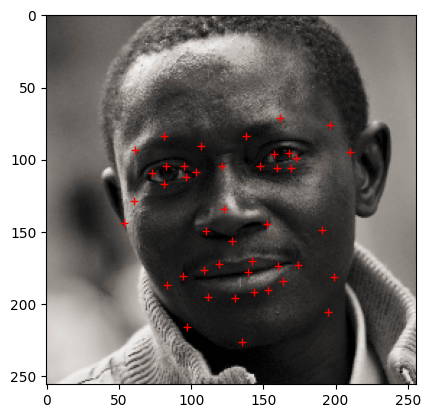

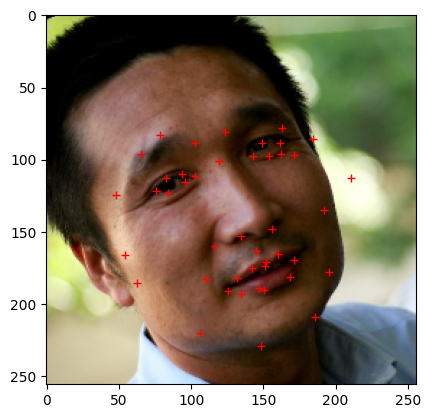

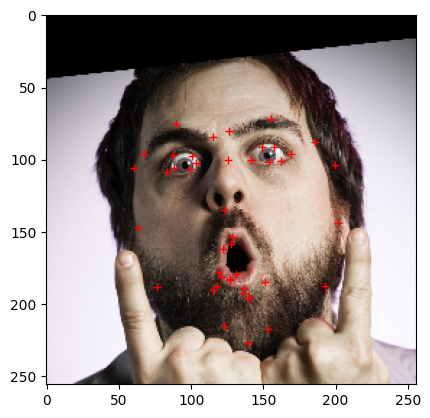

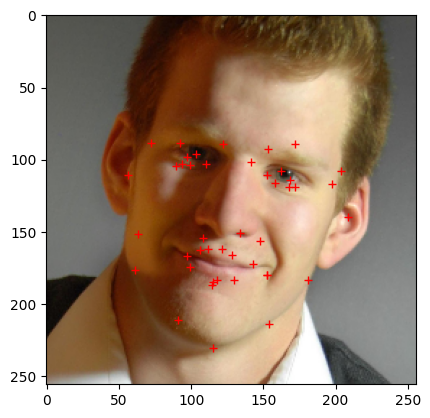

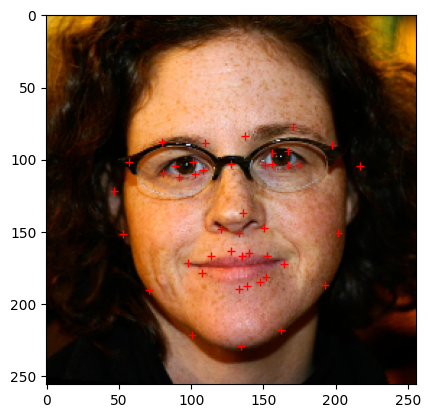

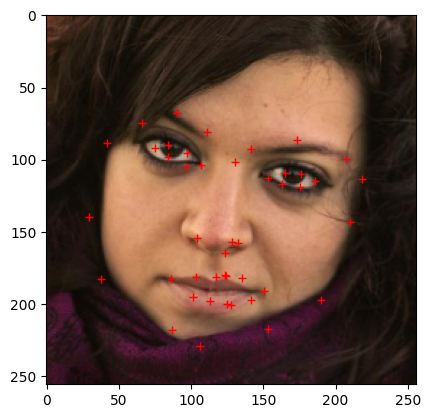

In [ ]:
for i in range(0, len(example_images)):
    visualise_pts(example_images[i], example_pred_pts[i])


**Visualize the lip and eye color on example images**

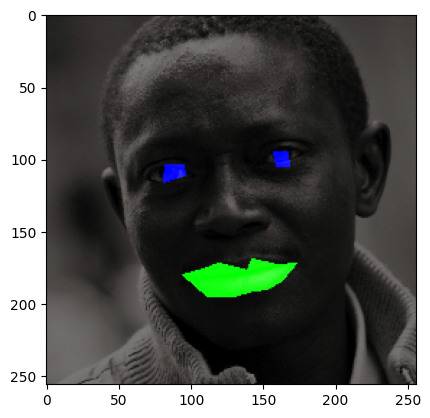

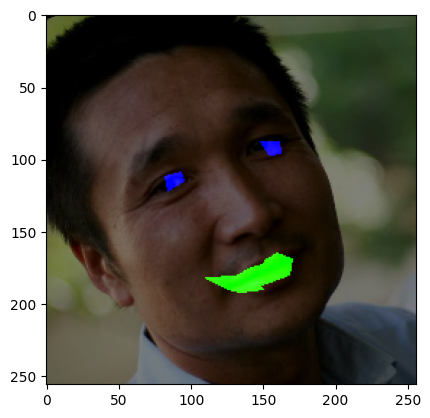

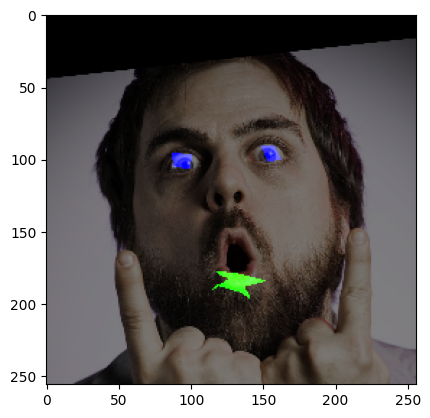

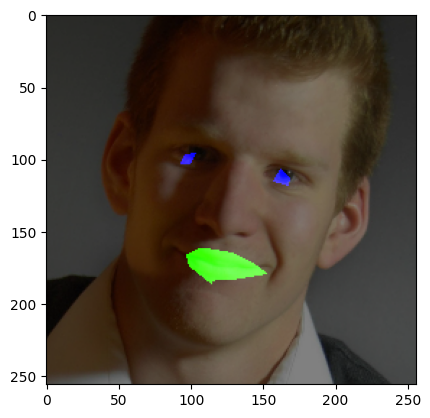

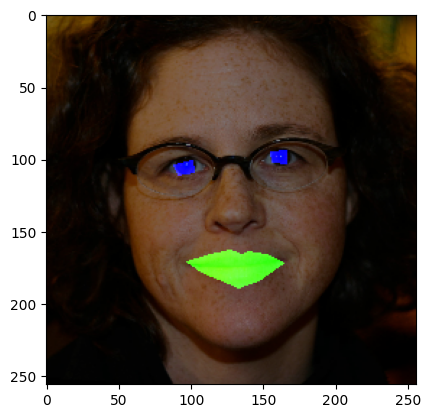

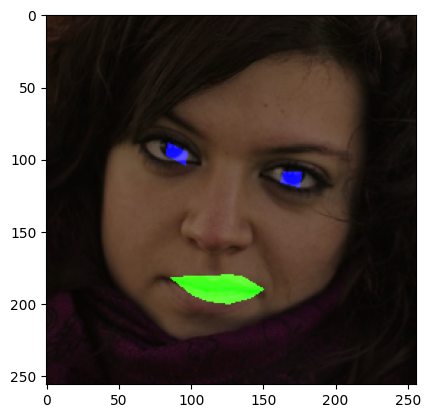

In [ ]:
for i in range(0, len(example_images)):
    color_fill(example_images[i], example_pred_pts[i])

**Save the test image points in .csv file**

In [ ]:
model = load_model("train_model.mdl")
pred_pts = model.predict(test_images)
save_as_csv(pred_pts)


  0%|          | 0/44 [00:00<?, ?it/s]